# Weather Image Recognition

# Imports

In [17]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [27]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process_images(img_path, target_size=(250, 250)):
  try:
    with Image.open(img_path) as img:
      img = img.resize(target_size)
      img = img.convert("RGB")
      
      img_array = np.array(img)/ 255.0
      img_array = img_array.astype(np.float32)
    return img_array
  except IOError as e:
    print(f"Error loading image {img_path}: {e}")
    return None

def grab_images(directory):
  
  images, labels = [], []

  for root, dir, files in os.walk(directory):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", "jpg")):
        file_path = os.path.join(root, file)
        img = load_process_images(file_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  return images, labels

def check_image_class_balance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10,6))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10,6))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.title("Count plot of target classes")
  plt.xticks(rotation=45)
  plt.show()

def create_model(n_classes):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_size=(250,250,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  
  model.summary()
  
  return model

# Model Description

## MaxPooling2D(2,2):

- Purpose: To reduce the spatial dimensions (width and height) of the input volume. This reduces the number of parameters and computations in the network, and it also helps to make the detected features more robust to spatial variations.
(2,2) Pool Size: This is a common choice as it reduces each dimension by a factor of 2, effectively reducing the volume of the feature map by 75%. For instance, if the input size is 64x64, max pooling with (2,2) would reduce it to 32x32.

## Conv2D with (3,3) Kernel Size:

- Purpose: To apply a filter to the input volume and generate feature maps. The filters (or kernels) slide over the input spatial dimensions (width and height) to detect various features.
(3,3) Kernel Size: This is a common choice because it is large enough to capture simple patterns like edges and textures but not too large to miss finer details. It strikes a balance between complexity and computational efficiency.

## Flatten Layer:

- Purpose: To convert the 3D output of the convolutional layers into a 1D vector that can be fed into fully connected (dense) layers. The dense layers require a 1D input.
Transition: This is necessary because convolutional layers preserve the spatial structure of the data, while dense layers do not.

## Dense Layer after Flatten Layer:

- Purpose: To perform classification based on the features extracted by the convolutional layers. The dense layer can learn complex combinations of these features.
- Dense(64, activation="relu"): The dense layer with 64 neurons can learn high-level combinations of features. The ReLU activation introduces non-linearity, allowing the model to learn more complex functions.

# Load Dataset

In [3]:
PATH = "/Users/maukanmir/Downloads/dataset/"

In [13]:
X, y = grab_images(PATH)

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [20]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 4116
Validation set size: 1373
Test set size: 1373


# Check Class Imabalance

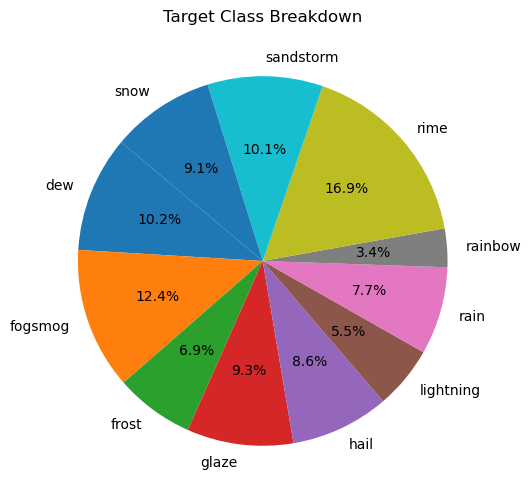

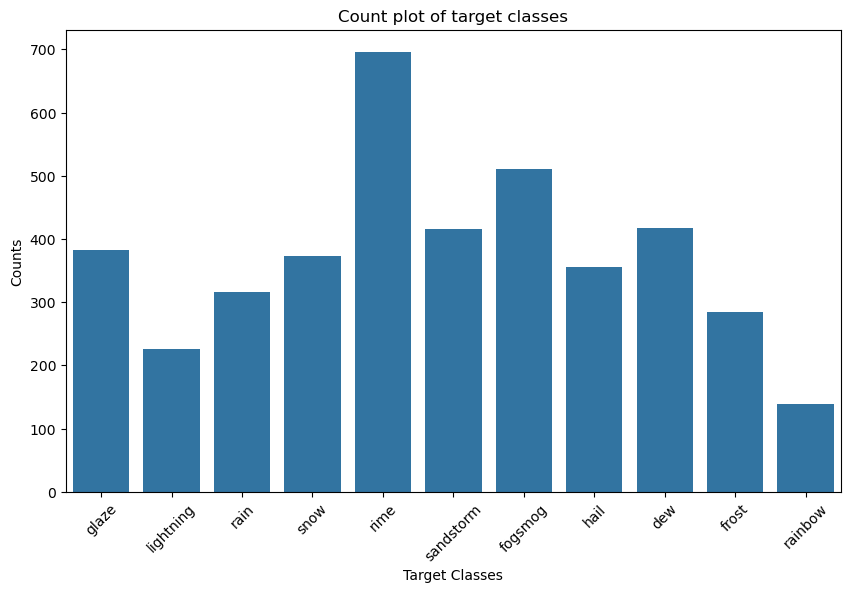

In [22]:
check_image_class_balance(y_train)

# Data Augmentation

In [26]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode="nearest"
)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train, y_train,
  batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow(
  X_val, y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test, y_test,
  batch_size=BATCH_SIZE
)

# Create Model

In [ ]:
model = create_model()

# Train Model

In [ ]:
history = model.fit(
  train_generator,
  steps_per_epoch=len(X_train)//BATCH_SIZE,
  epcohs=10,
  validation_data=validation_generator,
  validation_steps=len(X_val)//BATCH_SIZE
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // 32)
print(f"Test accuracy: {test_accuracy}")